In [ ]:
# Random Forest classifier for abstracts from Pubmed (https://pubmed.ncbi.nlm.nih.gov/).
# 2000 abstracts from 5 categories were downloaded.  The category name was entered in the search box and the
# first 2000 abstracts were saved.  Some abstracts are not very good examples of the category, but this
# helps since it is more realistic.The abstracts were saved in "Pubmed" file format and had to be parsed to extract
# just the abstract from each record.  Parsed files are zipped.

# The categories are:
# -Dental caries
# -Dental pulp
# -Periodontal disease
# -Endodontic treatment
# -Transposable elements

# Abstracts were preprocessed, then TF-IDF vectors were created to use as input.  Other vectorization
# could be used.  Mostly default hyperparameters were used in order to demonstrate how to do classification.
# Try using grid search to see if you can get better accuracy results.

# Last updated 12/4/20.

In [1]:
# Imports
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize 
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from termcolor import colored


# Variables
num_features_to_display = 20


c:\users\john.pace\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Count of each class of abstract:
transposable_elements    1991
endodontic_treatment     2000
dental_caries            2000
periodontal_disease      2000
dental_pulp              2000
Name: abstract_class, dtype: int64


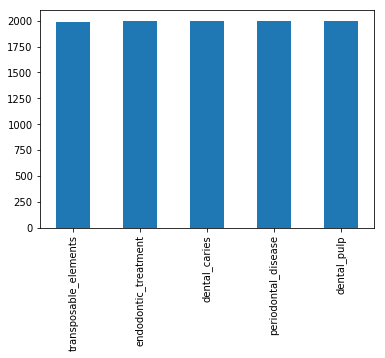

In [2]:
# Read the input files with the abstracts for train/test
pubmed = pd.read_csv("all_combined_abstracts.csv", header=None)
pubmed.columns = ["abstract_text", "abstract_class"]
X, y = pubmed["abstract_text"], pubmed["abstract_class"]

# Some descriptive stats on the abstract
# Count of each class of abstract
print(colored("Count of each class of abstract:", "red"))
print(pubmed.abstract_class.value_counts().sort_values(ascending=True))

# Print bar chart with values for each class
pubmed.abstract_class.value_counts().sort_values(ascending=True).plot.bar()
plt.show()

In [3]:
# processed_abstracts will be the list of all the processed abstracts
processed_abstracts = []

# Instantiate lemmatizer and stemmer
wnlemmatizer = WordNetLemmatizer()
ps = PorterStemmer() 

#i = 0
# Loop through all abstracts and pre-process
for abstract in X:
    #i += 1
    #if not i % 10:
    #    print(str(i))

    # Replace section names
    section_names = ["AIM: ", "OBJECTIVE: ", "RESULTS: ", "OBJECTIVES: ", "SELECTION: ", "PURPOSE: ",
                    "INTRODUCTION: ", "METHODS: ", "CONCLUSIONS: ", "MATERIALS AND METHODS: ", 
                    "BACKGROUND: ", "CASE DESCRIPTION: ", "CLINICAL SIGNIFICANCE: ", 
                    "STUDY DESIGN: ", "CONCLUSION: "]
    for section in section_names:
        abstract = abstract.replace(section, "")
        
    # Replace periods and double spaces
    abstract = abstract.replace(".  ", " ").replace(". ", " ").replace("  ", " ")
    
    # Remove all the special characters
    abstract = re.sub(r'\W', ' ', abstract)
    
    # Remove all numbers except those appearing in words, such as APOBEC3
    abstract = re.sub(r'\b\d+\b', ' ', abstract)
    
    # Convert to Lowercase
    abstract = abstract.lower()
        
    # Lemmatatize words
    abstract = word_tokenize(abstract)
    abstract = ' '.join([wnlemmatizer.lemmatize(word) for word in abstract])
    
    # Stem words
    abstract = ''.join([ps.stem(word) for word in abstract])
        
    processed_abstracts.append(abstract)

In [4]:
# Check to make sure the above worked
#print(processed_abstracts[0:2])

In [5]:
# Perform TF-IDF vectorization, removing stopwords
# Instantiate vectorizer
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
# Transform X for training
X = tfidfconverter.fit_transform(processed_abstracts).toarray()
# Get the feature names to be used later for feature importance
feature_name_list = tfidfconverter.get_feature_names()


In [6]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Feature Importance
caries: 0.07085
periodontal: 0.06652
pulp: 0.05641
disease: 0.04542
endodontic: 0.04218
element: 0.02894
canal: 0.02748
transposable: 0.02512
dental: 0.02066
root: 0.02064
cell: 0.02012
genome: 0.01517
child: 0.01456
gene: 0.01346
treatment: 0.01318
sequence: 0.01249
transposon: 0.01080
dna: 0.01080
pulpal: 0.01003
lesion: 0.00941
endodontics: 0.00829


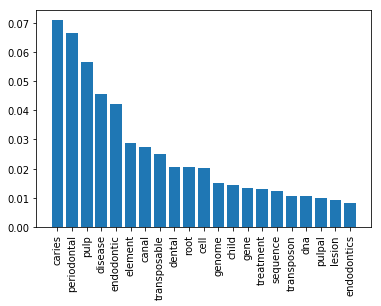

In [7]:
# Instantiate classifier with mostly default hyperparameters
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
# Fit classifier
rf_classifier.fit(X_train, y_train) 

# Print feature importance for features over a certain threshold
features_dict = {}
for i,v in enumerate(rf_classifier.feature_importances_):
    features_dict[v] = feature_name_list[i]

# Print sorted list of values
print(colored("Feature Importance", "red"))
i = 0
small_features_dict = {}
for key in sorted(features_dict, reverse=True):
    if i <= num_features_to_display:
        print("%s: %.5f" % (features_dict[key], key))
        small_features_dict[features_dict[key]] = key
        i += 1

# Plot feature importance variables
plt.bar(small_features_dict.keys(), small_features_dict.values())
plt.xticks(rotation='vertical')
plt.show()

In [8]:
# Run prediction on test set
y_pred = rf_classifier.predict(X_test)


Accuracy: 0.96048 

Classification Report:
                       precision    recall  f1-score   support

        dental_caries       0.96      0.95      0.96       376
          dental_pulp       0.96      0.92      0.94       403
 endodontic_treatment       0.92      0.96      0.94       418
  periodontal_disease       0.97      0.97      0.97       391
transposable_elements       1.00      1.00      1.00       411

          avg / total       0.96      0.96      0.96      1999

Confusion Matrix:


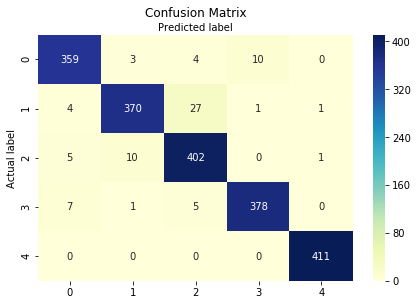

In [9]:
# Print the metrics

print("\nAccuracy: %.5f " % (accuracy_score(y_test, y_pred)))

print(colored("\nClassification Report:", "red"))
print(classification_report(y_test,y_pred))

print(colored("Confusion Matrix:", "red"))
# Prepare the plot
fig, ax = plt.subplots()
tick_marks = np.arange(len(rf_classifier.classes_))
plt.xticks(tick_marks, rf_classifier.classes_)
plt.yticks(tick_marks, rf_classifier.classes_)

# Create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred)), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


In [16]:
# Predict on unseen data, one for each category
dental_caries_prediction = "Aim: The aim of the study was to measure the efficiency of printed health education matters with reference to caries prevention and the endurance of knowledge acquired. Material and methods: The study included 74 parents of children coming from three kindergartens in the town of Plovdiv. Results: The results showed that the information was received well by the parents (86.2% correct answers). The repeated test after 6 months showed worse results than those from the first test, with an increase of the wrong answers (1st test - 14 wrong and 36 incomplete answers; 2nd test - 29 wrong and 44 incomplete answers). Conclusions: The information in this form is received well by the parents but requires periodic repetition for the purpose of assimilating the newly-acquired knowledge"
dental_pulp_prediction = "The correlation between reduction of the coronal pulp cavity and chronological age was examined in a sample of 846 intact teeth from 433 individuals of known age and sex. Panoramic (rotational) radiography was used to measure the height (mm) of the crown (CH = coronal height) and the height (mm) of the coronal pulp cavity (CPCH = coronal pulp cavity height) of 425 premolars and 421 molars from 213 males and 220 females. The tooth-coronal index (TCI) after Ikeda et al. [1985] Jpn. J. For. Med. 39:244-250) was computed for each tooth and regressed on real age. The correlation coefficients ranged from -0.92 (molars, combined sample, right side) to -0.87 (female molars), with an S.E. of the estimate ranging from 5.88-6.66 years. Correlations were slightly higher in males than females. The equations obtained allowed estimation of age in a sample of 100 teeth from both sexes (not used for the regression) with an error of +/- 5 years in 81.4% of cases for male molars. The regression formulae for estimating age obtained from the recent sample were tested on a historical sample of 100 teeth from 100-year-old skeletons with an error of +/- 5 years in 70.3% of cases for male molars. This study illustrates the potential value of a little-known aging method which can be easily applied to estimate age in both living individuals and skeletal material of unknown age."
endodontic_treatment_prediction = "Purpose: To evaluate 1) if glass ionomer interim temporary restorations (ITR) placed for 1-3 months prior to vital pulp therapy (VPT) improved accuracy of diagnosing the pulp's clinical status and subsequent VPT success, and 2) the effect of the location of the carious lesion on VPT. Methods: Primary molars (N=117) receiving pulp therapy with or without ITR were evaluated retrospectively. All teeth had caries extending >50 percent into dentin; caries lesion location was identified (proximal or non-proximal). Two examiners rated pulp status assessment, caries location, and pulp treatment, and correlated treatment outcomes after a mean of 34.7 months to these factors. Results: VPT failed more often in first primary molars (P<.001) than in second primary molars. Using ITR improved diagnosis of the pulp status, clinical success of VPT, (P=.013) and first molar VPT success (P=.02). First primary molars had more proximal lesions than second molars (P<.001). Failure of VPT was greater for teeth with proximal lesions (P=.03). Use of ITR significantly improved VPT in teeth with proximal lesions (P=.007) but not non-proximal lesions (P=.38). Conclusions: ITR placed prior to VPT improved pulpal diagnosis and VPT outcomes. Vital pulp therapy was less successful in primary molars with proximal lesions, and ITR significantly improved the success."
periodontal_disease_prediction = "The clinical effects of systemic penicillin and erythromycin on the periodontium were investigated. There are only a few studies of the effects of these antibiotics on clinical periodontal parameters. Of the 72 subjects in the study, 24 belonged to the penicillin group, 21 to the erythromycin group and 27 to the control group. Plaque and gingival indices, tooth mobility, and probing depths of gingival pockets were recorded before the drug treatment. Radiographs were taken. Both antibiotics decreased plaque, and erythromycin also decreased gingivitis. In the penicillin group 10 of the 24 patients developed abscesses during the study, and the studied clinical parameters worsened. These patients had more severe periodontitis initially than the persons with no acute reaction. The clinical changes had returned to the baseline level by 12 weeks after the antibiotic treatments. There were no significant or lasting effects of antibiotic treatment alone in patients with overt periodontitis."
transposable_elements_prediction = "The genetic determination of the control of resistance or susceptibility to germ line changes mediated by P elements was studied in two strains and in derivatives of crosses between them. One strain, characterized as true M, completely lacked P elements. The second strain, pseudo-M (M'), carried a number of P elements, but these did not have the potential to induce the gonadal sterility that is associated with P-M hybrid dysgenesis. Individuals from the true M strain were invariably unable to suppress P factor activity (i.e., all daughters of outcrosses of M females and P males were sterile). In contrast, individuals from the M' strain showed variable degrees of suppression that were manifested in a wide range of gonadal sterility frequencies in standard tests. This continuous distribution pattern was reproducible for more than 25 generations.--The results of the genetic analysis indicate that a strain with a variable degree of suppression of gonadal dysgenesis is not necessarily in a transient state between the extreme conditions of P and M cytotype. A large variance in the ability to suppress gonadal dysgenesis with a mean value intermediate between the extremes of P and M cytotype may be a relatively stable strain characteristic. No reciprocal cross effect was observed in the suppression of sterility of F1 females from M X M' matings. Thus, the existence of M' strains indicates a Mendelian component in P element regulation and suggests that cytotype, which has an extrachromosomal aspect, may be only one of perhaps several mechanisms involved in regulation. Analysis of the effects of individual chromosomes from the M' strain showed that each chromosome contributed to the reduction of gonadal dysgenesis in the progeny of test matings. The results are consistent with a one-component titration model for P element regulation."
combined_prediction = transposable_elements_prediction + periodontal_disease_prediction

all_test_abstracts = [dental_caries_prediction, dental_pulp_prediction, endodontic_treatment_prediction, 
                     periodontal_disease_prediction, transposable_elements_prediction, combined_prediction]
correct_predictions = ["dental_caries", "dental_pulp", "endodontic_treatment", 
                     "periodontal_disease", "transposable_elements", "transposable_elements/periodontal_disease"]

# Make predictions and print
for i in range(0, len(all_test_abstracts)):
    
    test_abstract = tfidfconverter.transform([all_test_abstracts[i]])

    prediction_class = rf_classifier.predict(test_abstract)[0]
    prediction_probability = rf_classifier.predict_proba(test_abstract)[0][np.argmax(rf_classifier.predict_proba(test_abstract))]
    print("Prediction: %s, %.5f.  Correct is %s." % (prediction_class, prediction_probability, correct_predictions[i]))
    

Prediction: dental_caries, 0.88000.  Correct is dental_caries.
Prediction: dental_pulp, 0.76750.  Correct is dental_pulp.
Prediction: dental_caries, 0.45000.  Correct is endodontic_treatment.
Prediction: periodontal_disease, 0.82000.  Correct is periodontal_disease.
Prediction: transposable_elements, 0.87000.  Correct is transposable_elements.
Prediction: periodontal_disease, 0.54000.  Correct is transposable_elements/periodontal_disease.


In [11]:
# Save to pickle file
with open('rf_abstract_classifier', 'wb') as picklefile:
    pickle.dump(rf_classifier,picklefile)
    